In [1]:
pip install yfinance

     |████████████████████████████████| 6.4 MB 8.6 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


import yfinance as yf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Enter the # of categories you want for your x variables
3
enter the ticker you want to predict in the end:
TSLA
do you want a visualization? (yes/no):
no
the stocks in your selected categories will be stacked on top of each other for training purposes, how many days back would you like each stock to go? (i.e. 10 days: 10 days of past returns for each stock):
20
how many trees do you want the random forest to have?:
2000
Do you need to scrape companymarketcap.com (yes/no) (only need to do once / runtime):
no
For each stock, we are predicting returns xx days into the future. How many days would you like to lag your data:
1
yahoo finance data collection (on/off) (every time you change category selection):
on
Quick setup (on/off):
on
run a random forest: (yes/no)
yes
run a xgboost (yes/no):
yes
run a logit (yes/no):
no
run a gradient boosted (yes/no):
yes
no visualization
no scrape
enter your industry categories, according to the number you referrenced above
tech
internet
software
AAPL
MSF

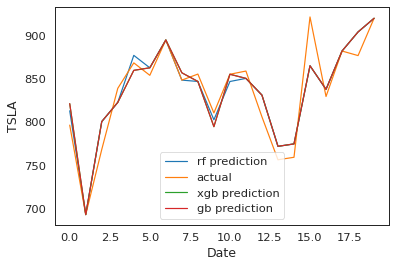

In [75]:
from bs4.element import DEFAULT_OUTPUT_ENCODING
print('Enter the # of categories you want for your x variables')
num_categories = int(input())
print('enter the ticker you want to predict in the end:')  
ticker = input()
print('do you want a visualization? (yes/no):')
descriptive = input()
print('the stocks in your selected categories will be stacked on top of each other for training purposes, how many days back would you like each stock to go? (i.e. 10 days: 10 days of past returns for each stock):')
days_back = int(input())
print('how many trees do you want the random forest to have?:')
num_trees = int(input())
print('Do you need to scrape companymarketcap.com (yes/no) (only need to do once / runtime):')
scrape = input()
print('For each stock, we are predicting returns xx days into the future. How many days would you like to lag your data:')
shift = int(input())
start_date = '2021-09-03'
print('yahoo finance data collection (on/off) (every time you change category selection):')
setup = input()
print('Quick setup (on/off):')
shift_change = input()
print('run a random forest: (yes/no)')
random_forest = input()
print('run a xgboost (yes/no):')
xgb = input()
print('run a logit (yes/no):')
logi_regression = input()
print('run a gradient boosted (yes/no):')
gradient_boosted = input()

#------------------------------------------------------

if descriptive == 'yes':
  msft = yf.Ticker(ticker.upper())
  df = msft.history(period="max")
  df = df.iloc[7000:]
  df = df.reset_index()

  df['date_time'] = df['Date']
  df = df.dropna()
  df['date_time']=pd.to_datetime(df['date_time']) 
  df['year'] = df['date_time'].apply(lambda x: x.year)
  df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
  df['month'] = df['date_time'].apply(lambda x: x.month)
  df['day'] = df['date_time'].apply(lambda x: x.day)
  df=df.loc[:,['date_time','Close', 'year','quarter','month','day']]
  df.sort_values('date_time', inplace=True, ascending=True)
  df = df.reset_index(drop=True)
  df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
  df["weekday"] = (df["weekday"] < 5).astype(int)
  print('Number of rows and columns after removing missing values:', df.shape)
  print('The time series starts from: ', df.date_time.min())
  print('The time series ends on: ', df.date_time.max())

  stat, p = stats.normaltest(df.Close)
  print('Statistics=%.3f, p=%.3f' % (stat, p))
  alpha = 0.05
  if p > alpha:
      print('Data looks Gaussian (fail to reject H0)')
  else:
      print('Data does not look Gaussian (reject H0)')

  sns.distplot(df.Close);
  print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Close)))
  print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Close)))

  df1=df.loc[:,['date_time','Close']]
  df1.set_index('date_time',inplace=True)
  df1.plot(figsize=(12,5))
  plt.ylabel('MSFT')
  plt.legend().set_visible(False)
  plt.tight_layout()
  plt.title('Microsoft Time Series')
  sns.despine(top=True)
  plt.show();

  plt.figure(figsize=(14,5))
  plt.subplot(1,2,1)
  plt.subplots_adjust(wspace=0.2)
  sns.boxplot(x="year", y="Close", data=df)
  plt.xlabel('year')
  plt.title('Box plot of MSFT stock')
  sns.despine(left=True)
  plt.tight_layout()
  plt.subplot(1,2,2)
  sns.boxplot(x="quarter", y="Close", data=df)
  plt.xlabel('quarter')
  plt.title('Box plot of Quarterly Stock Closing Prices')
  sns.despine(left=True)
  plt.tight_layout();

  plt.figure(figsize=(14,6))
  plt.subplot(1,2,1)
  df['Close'].hist(bins=50)
  plt.title('MSFT Closing Price Distribution')
  plt.subplot(1,2,2)
  stats.probplot(df['Close'], plot=plt);
  df1.describe().T

  fig = plt.figure(figsize=(18,16))
  fig.subplots_adjust(hspace=.4)
  ax1 = fig.add_subplot(5,1,1)
  ax1.plot(df1['Close'].resample('D').mean(),linewidth=1)
  ax1.set_title('Mean MSFT Closing Price resampled over day')
  ax1.tick_params(axis='both', which='major')

  ax2 = fig.add_subplot(5,1,2, sharex=ax1)
  ax2.plot(df1['Close'].resample('W').mean(),linewidth=1)
  ax2.set_title('Mean MSFT Closing Price power resampled over week')
  ax2.tick_params(axis='both', which='major')

  ax3 = fig.add_subplot(5,1,3, sharex=ax1)
  ax3.plot(df1['Close'].resample('M').mean(),linewidth=1)
  ax3.set_title('Mean MSFT Closing Price resampled over month')
  ax3.tick_params(axis='both', which='major')

  ax4  = fig.add_subplot(5,1,4, sharex=ax1)
  ax4.plot(df1['Close'].resample('Q').mean(),linewidth=1)
  ax4.set_title('Mean MSFT Closing Price over quarter')
  ax4.tick_params(axis='both', which='major')

  ax5  = fig.add_subplot(5,1,5, sharex=ax1)
  ax5.plot(df1['Close'].resample('A').mean(),linewidth=1)
  ax5.set_title('Mean MSFT Closing Price resampled over year')
  ax5.tick_params(axis='both', which='major');

  plt.figure(figsize=(14,8))
  plt.subplot(2,2,1)
  df.groupby('year').Close.agg('mean').plot()
  plt.xlabel('')
  plt.title('Mean MSFT Closing Price by Year')

  plt.subplot(2,2,2)
  df.groupby('quarter').Close.agg('mean').plot()
  plt.xlabel('')
  plt.title('Mean MSFT Closing Price by Quarter')

  plt.subplot(2,2,3)
  df.groupby('month').Close.agg('mean').plot()
  plt.xlabel('')
  plt.title('Mean MSFT Closing Price by Month')

  plt.subplot(2,2,4)
  df.groupby('day').Close.agg('mean').plot()
  plt.xlabel('')
  plt.title('Mean MSFT Closing Price by Day');


  pd.pivot_table(df.loc[df['year'] != 2013], values = "Close", 
                columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

  dic={0:'Weekend',1:'Weekday'}
  df['Day'] = df.weekday.map(dic)
  a=plt.figure(figsize=(9,4)) 
  plt1=sns.boxplot('year','Close',hue='Day',width=0.6,fliersize=3,
                      data=df)                                                                                                                                                                                                                                                                                                                                                 
  a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
  sns.despine(left=True, bottom=True) 
  plt.xlabel('')
  plt.tight_layout()                                                                                                                  
  plt.legend().set_visible(False);

  plt1=sns.factorplot('year','Close',hue='Day',
                      data=df, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
  plt.title('Factor Plot of MSFT Closign Price by Weekend/Weekday')                                                             
  plt.tight_layout()                                                                                                                  
  sns.despine(left=True, bottom=True) 
  plt.legend(loc='upper right');
else:
  print('no visualization')

if scrape == 'yes':
  urls = [
    'https://companiesmarketcap.com/automakers/largest-automakers-by-market-cap/',
    'https://companiesmarketcap.com/automakers/largest-automakers-by-market-cap/',
    'https://companiesmarketcap.com/airlines/largest-airlines-by-market-cap/',
    'https://companiesmarketcap.com/airports/largest-airport-operating-companies-by-market-cap/',
    'https://companiesmarketcap.com/aircraft-manufacturers/largest-aircraft-manufacturers-by-market-cap/',
    'https://companiesmarketcap.com/banks/largest-banks-by-market-cap/',
    'https://companiesmarketcap.com/hotels/largest-hotel-companies-by-market-cap/',
    'https://companiesmarketcap.com/pharmaceuticals/largest-pharmaceutical-companies-by-market-cap/',
    'https://companiesmarketcap.com/e-commerce/largest-e-commerce-companies-by-market-cap/',
    'https://companiesmarketcap.com/healthcare/largest-healthcare-companies-by-market-cap/',
    'https://companiesmarketcap.com/ports/largest-port-operating-companies-by-market-cap/',
    'https://companiesmarketcap.com/professional-services/largest-professional-service-companies-by-market-cap/',
    'https://companiesmarketcap.com/food/largest-food-companies-by-market-cap/',
    'https://companiesmarketcap.com/restaurant-chains/largest-restaurant-chain-companies-by-market-cap/',
    'https://companiesmarketcap.com/software/largest-software-companies-by-market-cap/',
    'https://companiesmarketcap.com/semiconductors/largest-semiconductor-companies-by-market-cap/',
    'https://companiesmarketcap.com/tobacco/largest-tobacco-companies-by-market-cap/',
    'https://companiesmarketcap.com/financial-services/largest-financial-service-companies-by-market-cap/',
    'https://companiesmarketcap.com/oil-gas/largest-oil-and-gas-companies-by-market-cap/',
    'https://companiesmarketcap.com/electricity/largest-electricity-companies-by-market-cap/',
    'https://companiesmarketcap.com/delivery-services/largest-delivery-companies-by-market-cap/',
    'https://companiesmarketcap.com/media-press/largest-media-and-press-companies-by-market-cap/',
    'https://companiesmarketcap.com/alcoholic-beverages/largest-alcoholic-beverage-companies-by-market-cap/',
    'https://companiesmarketcap.com/beverages/largest-beverage-companies-by-market-cap/',
    'https://companiesmarketcap.com/clothing/largest-clothing-companies-by-market-cap/',
    'https://companiesmarketcap.com/mining/largest-mining-companies-by-market-cap/',
    'https://companiesmarketcap.com/railways/largest-railways-companies-by-market-cap/',
    'https://companiesmarketcap.com/insurance/largest-insurance-companies-by-market-cap/',
    'https://companiesmarketcap.com/real-estate/largest-real-estate-companies-by-market-cap/',
    'https://companiesmarketcap.com/chemicals/largest-chemical-companies-by-market-cap/',
    'https://companiesmarketcap.com/investment/largest-investment-companies-by-market-cap/',
    'https://companiesmarketcap.com/telecommunication/largest-telecommunication-companies-by-market-cap/',
    'https://companiesmarketcap.com/retail/largest-retail-companies-by-market-cap/',
    'https://companiesmarketcap.com/internet/largest-internet-companies-by-market-cap/',
    'https://companiesmarketcap.com/construction/largest-construction-companies-by-market-cap/',
    'https://companiesmarketcap.com/tech/largest-tech-companies-by-market-cap/'
  ]
  a = []
  for x in range(len(urls)):
      a.append(urls[x].split('/')[3])
  a

  import requests
  import time
  import bs4
  from bs4 import BeautifulSoup
  cats = ['automakers','airlines','aircraft-manufacturers','banks','pharmaceuticals','e-commerce','healthcare','ports','professional-services','food','restaurant-chains','software','semiconductors','tobacco','financial-services','electricity','courier-services','media/press','alcoholic-beverages','beverages','clothing','mining','railways','insurance','real-estate','chemicals','investment','telecomunication','retail','internet','construction','tech']
  cat_names = {'category':[],'names':[],'ticker':[]}
  try:
      for x in range(len(urls)):
          url = urls[x]
          html = requests.get(url).text
          soup = bs4.BeautifulSoup(html, "html.parser")
          for tag in soup.findAll("div", {"class": "name-div"}):
                  cat_names['names'].append(tag.findNext("div").text)
                  cat_names['category'].append(a[x])
          for tag in soup.findAll("div", {"class": "company-name"}):
                  cat_names['ticker'].append(tag.findNext().text)

  except:
      print(x)
else:
  print('no scrape')

if setup == 'on':
  cat_names = pd.DataFrame(cat_names)
  print('enter your industry categories, according to the number you referrenced above')
  gg = []  
  tech = pd.DataFrame()
  cat_holder = []
  for x in range(num_categories):
    x = input()
    cat_holder.append(x)
    tech = (cat_names['ticker'][cat_names['category']==x])
    gg.append(tech)
  tech = pd.concat(gg,ignore_index = True)
  tech = tech.drop_duplicates()
    

  for x in range(len(tech)):
    try:
        xx  = yf.Ticker(tech.iloc[x])
        df = xx.history(period="max")
        df.columns.values[0] = tech.iloc[x]+" Open"
        df.columns.values[1] = tech.iloc[x]+" High"
        df.columns.values[2] = tech.iloc[x]+" Low"
        df.columns.values[3] = tech.iloc[x]+" Close"
        df.columns.values[4] = tech.iloc[x]+" Volume"
        df.columns.values[5] = tech.iloc[x]+" Dividends"
        df.columns.values[6] = tech.iloc[x]+" Stock Splits"
        tech.iloc[x] = df.reset_index()
    except:
      print(tech.iloc[x])
  

  from sklearn import preprocessing
  from sklearn.model_selection import train_test_split
  from sklearn.ensemble import RandomForestClassifier
  from sklearn import metrics
  import time
  label_encoder = preprocessing.LabelEncoder()

  msft = yf.Ticker(ticker)
  df = msft.history(period="max")

  for ii in range(len(tech)):
    if len(tech.iloc[ii])>=days_back-shift:
      df = pd.merge(df, tech.iloc[ii] ,on = 'Date')
    else:
      print('not long enough!')
  
  for x in range(num_categories):
    tech = (cat_names['ticker'][cat_names['category']==pd.DataFrame(cat_holder)[0][x]])
    gg.append(tech)
  tech = pd.concat(gg,ignore_index = True)

  tech = tech.reset_index()
  tech = tech.drop(columns = 'index')
  tech.drop_duplicates()
  tech = tech['ticker']
  aa = pd.DataFrame()
  vol = pd.DataFrame()
  ss = []
  for i in range(len(tech)):
    try:
      aa[str(tech.iloc[i])] = (df[str(tech.iloc[i])+' Close']- df[str(tech.iloc[i])+' Open'])/df[str(tech.iloc[i])+' Open']*100
      vol[str(tech.iloc[i])] = df[str(tech.iloc[i])+' Volume']
    except:
      ss.append(str(tech.iloc[i]))
  aa = round(aa)

  tech = pd.DataFrame(tech)

  dd = pd.DataFrame()

  rr = pd.DataFrame()
  for x in range(len(tech)):
    try:
      rr[tech.iloc[x]] = aa[tech.iloc[x]]
    except:
      print(tech.iloc[x])

  qq = pd.DataFrame()
  for x in range(len(tech)):
    try:
      qq[tech.iloc[x]] = aa[tech.iloc[x]]
    except:
      print(tech.iloc[x])



  ss = []
  df = pd.DataFrame()

  for x in range(len(tech)):
    try:
      df = qq.drop(columns = tech['ticker'][x])
      ss.append(df)
    except:
      print(tech['ticker'][x])


  pieces = []
  for x in range(len(tech)):
    try:
      pieces.append(ss[x].iloc[-1*days_back:]).shift(-1*shift).dropna()
    except:
      print(tech['ticker'][x])
  df_final = pd.concat(pieces,axis = False, ignore_index = True)


else:
      print('no setup')

if shift_change == 'on':
  y = []
  for x in range(len(tech)):
    try:
      y.append(qq[tech['ticker'][x]].iloc[-1*days_back:]).shift(shift).dropna()
    except:
      print(tech['ticker'][x])
  y = pd.concat(y, ignore_index = True)
  yy =y.reset_index()
  yy = yy.drop(columns = 'index')
  yy[0].loc[~(yy[0]==0)]
  
  yyy = pd.DataFrame()
  yy = yy.dropna()
  yyy['y'] = yy[0]
  yyy = yyy.reset_index()


  tt = round(df_final)
  tt = tt.fillna(1)
  xx = tt.reset_index()
  xx = xx.drop(columns = 'index')
  xx = xx.reset_index()
  
  xxx = pd.merge(yyy,xx, on = 'index')
  y = xxx['y']
  xxx = xxx.drop(columns = ['index','y'])

  x = xxx
  xx = x

  yy = y

  xxx = xx
  yyy = y
else:
  print('no setup')

if random_forest == 'yes':
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
  clf=RandomForestClassifier(n_estimators=num_trees)
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  print('random forest score = '+str(metrics.accuracy_score(y_test, y_pred)))

  xt = x.iloc[0:days_back]
  yt = x.iloc[days_back:days_back][ticker.upper()]
  yt = yt.reset_index().drop(columns = 'index')
  df_compare_rf = pd.DataFrame()
  df_compare_rf['prediction'] = list(clf.predict(xt))
  df_compare_rf['actual'] = yt
  df_compare_rf['dif'] = abs(df_compare_rf['actual']-df_compare_rf['prediction'])
  dd = len(df_compare_rf[df_compare_rf['dif']==0])
  accuracy = dd/len(df_compare_rf)*100
  print('random forest accuracy for last '+str(shift)+' '+ticker+' '+str(accuracy))


else:
  print('no random forest')

if logi_regression == 'yes':
  xx, yy = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=3, random_state=1)

  model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  n_scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)

  print('Logistic mean accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
  xt = x.iloc[0:days_back]
  yt = x.iloc[days_back:days_back*2][ticker.upper()]
  yt = yt.reset_index().drop(columns = 'index')
  df_compare_logit = pd.DataFrame()
  df_compare_logit['prediction'] = list(model.predict(xt))
  df_compare_logit['actual'] = yt
  df_compare_logit['dif'] = abs(df_compare_logit['actual']-df_compare_logit['prediction'])
  dd = len(df_compare_logit[df_compare_logit['dif']==0])
  accuracy = dd/len(df_compare_logit)*100
  print('logit accuracy for last '+str(shift)+' '+ticker+' '+str(accuracy))
else:
  print('no logistic regression')

if gradient_boosted == 'yes':
  X_train, X_test, y_train, y_test = train_test_split(xxx, yyy, test_size=0.2)

  lr_list = [0.05, 0.075, 0.1]

  for learning_rate in lr_list:
      gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
      gb_clf.fit(X_train, y_train)

      print("Learning rate: ", learning_rate)
      print("Gradient Boosted Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
      print("Gradient Boosted Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

  xt = x.head(days_back)
  yt = x.iloc[days_back:days_back*2][ticker.upper()]
  yt = yt.reset_index().drop(columns = 'index')
  df_compare_gb = pd.DataFrame()
  df_compare_gb['prediction'] = list(gb_clf.predict(xt))
  df_compare_gb['actual'] = yt
  df_compare_gb['dif'] = abs(df_compare_gb['actual']-df_compare_gb['prediction'])
  dd = len(df_compare_gb[df_compare_gb['dif']==0])
  accuracy = dd/len(df_compare_gb)*100
  print('gb forest accuracy for last '+str(shift)+' '+ticker+' '+str(accuracy))

else:
  print('no gradient boosted forests')


if xgb == 'yes':
  xgb_clf = XGBClassifier()
  xgb_clf.fit(X_train, y_train)
  score = xgb_clf.score(X_test, y_test)
  print('XGB Score = '+str(score))
  xt = x.head(50)
  yt = x.iloc[50:100][ticker.upper()]
  yt = yt.reset_index().drop(columns = 'index')
  df_compare_xgb = pd.DataFrame()
  df_compare_xgb['prediction'] = list(xgb_clf.predict(xt))
  df_compare_xgb['actual'] = yt
  df_compare_xgb['dif'] = abs(df_compare_xgb['actual']-df_compare_xgb['prediction'])
  dd = len(df_compare_xgb[df_compare_xgb['dif']==0])
  accuracy = dd/len(df_compare_xgb)*100
  print('xgb forest accuracy for last '+str(shift)+' '+ticker+' '+str(accuracy))

else:
  print('no xg boosted forest')

xt = xxx.head(days_back)
yt = xxx.iloc[days_back:days_back*2][ticker.upper()]
yt = yt.reset_index().drop(columns = 'index')
df_compare_rf = pd.DataFrame()
df_compare_rf['prediction'] = list(clf.predict(xt))
df_compare_rf['actual'] = yt
df_compare_rf['dif'] = abs(df_compare_rf['actual']-df_compare_rf['prediction'])
dd = len(df_compare_rf[df_compare_rf['dif']==0])
accuracy = dd/len(df_compare_rf)*100
print('rf forest accuracy for last '+str(shift)+' '+ticker+' '+str(accuracy))
msft = yf.Ticker(ticker)
df = msft.history(period="max")
dd = df['Open'].iloc[int(len(df))-days_back:]
df_ = {'open':[]}
for x in range(len(dd)):
  df_['open'].append(int(dd[x]))

df_final = pd.DataFrame()
df_final[str(ticker.upper())+' actual'] = df_['open'] + df_compare_rf['actual']/100*df_['open']
df_final[str(ticker.upper())+' prediction'] = df_['open'] + df_compare_rf['prediction']/100*df_['open']
x1 = df_final[str(ticker.upper())+' actual']
y1 = df_final[str(ticker.upper())+' prediction']

xtt = xxx.head(days_back)
ytt = xxx.iloc[days_back:days_back*2][ticker.upper()]
ytt = ytt.reset_index().drop(columns = 'index')
df_compare_xgb = pd.DataFrame()
df_compare_xgb['prediction'] = list(xgb_clf.predict(xt))
df_compare_xgb['actual'] = ytt
df_compare_xgb['dif'] = abs(df_compare_xgb['actual']-df_compare_xgb['prediction'])
ddd = len(df_compare_xgb[df_compare_xgb['dif']==0])
accuracyy = ddd/len(df_compare_xgb)*100
print('xgb forest accuracy for last '+str(shift)+' '+ticker+' '+str(accuracyy))
msftt = yf.Ticker(ticker)
dff = msftt.history(period="max")
ddd = dff['Open'].iloc[int(len(dff))-days_back:]
df__ = {'open':[]}
for x in range(len(ddd)):
  df__['open'].append(int(ddd[x]))

df_final_xgb = pd.DataFrame()
df_final_xgb[str(ticker.upper())+' actual'] = df__['open'] + df_compare_xgb['actual']/100*df__['open']
df_final_xgb[str(ticker.upper())+' prediction'] = df__['open'] + df_compare_xgb['prediction']/100*df__['open']
x11 = df_final_xgb[str(ticker.upper())+' prediction']

xttt = xxx.head(days_back)
yttt = xxx.iloc[days_back:days_back*2][ticker.upper()]
yttt = yttt.reset_index().drop(columns = 'index')
df_compare_gb = pd.DataFrame()
df_compare_gb['prediction'] = list(xgb_clf.predict(xt))
df_compare_gb['actual'] = ytt
df_compare_gb['dif'] = abs(df_compare_gb['actual']-df_compare_gb['prediction'])
dddd = len(df_compare_gb[df_compare_gb['dif']==0])
accuracyyy = dddd/len(df_compare_gb)*100
print('gb forest accuracy for last '+str(shift)+' '+ticker+' '+str(accuracyyy))
msfttt = yf.Ticker(ticker)
dfff = msfttt.history(period="max")
dddd = dfff['Open'].iloc[int(len(dfff))-days_back:]
df___ = {'open':[]}
for x in range(len(dddd)):
  df___['open'].append(int(dddd[x]))

df_finalll = pd.DataFrame()
df_finalll[str(ticker.upper())+' actual'] = df___['open'] + df_compare_gb['actual']/100*df___['open']
df_finalll[str(ticker.upper())+' prediction'] = df___['open'] + df_compare_gb['prediction']/100*df___['open']
x111 = df_finalll[str(ticker.upper())+' prediction']

ax = y1.head(20).plot(label='rf prediction')
ax = x1.head(20).plot(label='actual')
ax = x11.head(20).plot(label='xgb prediction')
ax = x111.head(20).plot(label='gb prediction')

ax.set_xlabel('Date')
ax.set_ylabel(str(ticker))
plt.legend()
plt.show()











In [74]:
df_finalll

,TSLA actual,TSLA prediction
0,834.0000,831.0000
1,701.0000,701.0000
2,814.0000,810.0000
3,812.0000,814.0000
4,869.0000,870.0000
5,874.0000,873.0000
6,876.0000,876.0000
7,849.0000,847.0000
8,856.0000,857.0000
9,793.0000,795.0000


In [ ]:
xt = xxx.head(days_back)
yt = xxx.iloc[days_back:days_back*2][ticker.upper()]
yt = yt.reset_index().drop(columns = 'index')
df_compare_rf = pd.DataFrame()
df_compare_rf['prediction'] = list(clf.predict(xt))
df_compare_rf['actual'] = yt
df_compare_rf['dif'] = abs(df_compare_rf['actual']-df_compare_rf['prediction'])
dd = len(df_compare_rf[df_compare_rf['dif']==0])
accuracy = dd/len(df_compare_rf)*100
print('rf forest accuracy for last '+str(shift)+' '+ticker+' '+str(accuracy))
msft = yf.Ticker(ticker)
df = msft.history(period="max")
dd = df['Open'].iloc[int(len(df))-days_back:]
df_ = {'open':[]}
for x in range(len(dd)):
  df_['open'].append(int(dd[x]))

df_final = pd.DataFrame()
df_final[str(ticker.upper())+' actual'] = df_['open'] - df_compare_rf['actual']
df_final[str(ticker.upper())+' prediction'] = df_['open'] - df_compare_rf['prediction']
x1 = df_final[str(ticker.upper())+' actual']
y1 = df_final[str(ticker.upper())+' prediction']




xtt = xxx.head(days_back)
ytt = xxx.iloc[days_back:days_back*2][ticker.upper()]
ytt = ytt.reset_index().drop(columns = 'index')
df_compare_xgb = pd.DataFrame()
df_compare_xgb['prediction'] = list(xgb_clf.predict(xt))
df_compare_xgb['actual'] = ytt
df_compare_xgb['dif'] = abs(df_compare_xgb['actual']-df_compare_xgb['prediction'])
ddd = len(df_compare_xgb[df_compare_xgb['dif']==0])
accuracyy = ddd/len(df_compare_xgb)*100
print('xgb forest accuracy for last '+str(shift)+' '+ticker+' '+str(accuracyy))
msftt = yf.Ticker(ticker)
dff = msftt.history(period="max")
ddd = dff['Open'].iloc[int(len(dff))-days_back:]
df__ = {'open':[]}
for x in range(len(ddd)):
  df__['open'].append(int(ddd[x]))

df_final_xgb = pd.DataFrame()
df_final_xgb[str(ticker.upper())+' actual'] = df_['open'] - df_compare_xgb['actual']
df_final_xgb[str(ticker.upper())+' prediction'] = df_['open'] - df_compare_xgb['prediction']
x11 = df_final_xgb[str(ticker.upper())+' prediction']





xttt = xxx.head(days_back)
yttt = xxx.iloc[days_back:days_back*2][ticker.upper()]
yttt = yttt.reset_index().drop(columns = 'index')
df_compare_gb = pd.DataFrame()
df_compare_gb['prediction'] = list(xgb_clf.predict(xt))
df_compare_gb['actual'] = ytt
df_compare_gb['dif'] = abs(df_compare_gb['actual']-df_compare_gb['prediction'])
dddd = len(df_compare_gb[df_compare_gb['dif']==0])
accuracyyy = dddd/len(df_compare_gb)*100
print('xgb forest accuracy for last '+str(shift)+' '+ticker+' '+str(accuracyyy))
msfttt = yf.Ticker(ticker)
dfff = msfttt.history(period="max")
dddd = dfff['Open'].iloc[int(len(dfff))-days_back:]
df___ = {'open':[]}
for x in range(len(dddd)):
  df___['open'].append(int(dddd[x]))

df_finalll = pd.DataFrame()
df_finalll[str(ticker.upper())+' actual'] = df___['open'] - df_compare_gb['actual']
df_finalll[str(ticker.upper())+' prediction'] = df___['open'] - df_compare_gb['prediction']
x111 = df_finalll[str(ticker.upper())+' prediction']




x = df_final[str(ticker.upper())+' prediction']
ax = x.head(20).plot(label='rf prediction')
ax = x1.head(20).plot(label='actual')
ax = x11.head(20).plot(label='xgb prediction')
ax = x111.head(20).plot(label='gb prediction')

ax.set_xlabel('Date')
ax.set_ylabel(str(ticker))
plt.legend()
plt.show()


In [ ]:
df_compare_gb['actual'] = ytt

In [ ]:
df_compare_gb['actual']

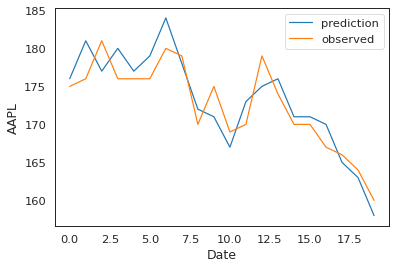

In [32]:
dd

Date
2021-12-27   176.8647
2021-12-28   179.9308
2021-12-29   179.1018
2021-12-30   179.2416
2021-12-31   177.8634
2022-01-03   177.6037
2022-01-04   182.3976
2022-01-05   179.3815
2022-01-06   172.4802
2022-01-07   172.6700
2022-01-10   168.8649
2022-01-11   172.1007
2022-01-12   175.8959
2022-01-13   175.5563
2022-01-14   171.1220
2022-01-18   171.2918
2022-01-19   169.7837
2022-01-20   166.7675
2022-01-21   164.2108
2022-01-24   159.8164
2022-01-25   158.7777
2022-01-26   163.2920
2022-01-27   162.2433
2022-01-28   165.4991
2022-01-31   169.9435
2022-02-01   173.7886
2022-02-02   174.5276
2022-02-03   174.2580
2022-02-04   171.6800
2022-02-07   172.8600
2022-02-08   171.7300
2022-02-09   176.0500
2022-02-10   174.1400
2022-02-11   172.3300
2022-02-14   167.3700
2022-02-15   170.9700
2022-02-16   171.8500
2022-02-17   171.0300
2022-02-18   169.8200
2022-02-22   164.9800
2022-02-23   165.5400
2022-02-24   152.5800
2022-02-25   163.8400
2022-02-28   163.0600
2022-03-01   164.7000
2022-

In [8]:
df_compare_xgb

,prediction,actual,dif
0,-0.0000,1.0000,1.0000
1,-2.0000,1.0000,3.0000
2,2.0000,1.0000,1.0000
3,-1.0000,1.0000,2.0000
4,-0.0000,1.0000,1.0000
5,-2.0000,1.0000,3.0000
6,-2.0000,1.0000,3.0000
7,1.0000,1.0000,0.0000
8,-0.0000,1.0000,1.0000
9,1.0000,1.0000,0.0000


In [ ]:
pred = results.get_prediction(start=start_date,dynamic=False)
pred_ci = pred.conf_int()
ax = y['2021':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label=str(shift*-1)+' Steps ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
              pred_ci.iloc[:, 0],
              pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel(str(ticker))
plt.legend()
plt.show()

In [ ]:
import yfinance as yf

# Get the data
data = yf.download(tickers="GZIC", period="5d", interval="1m")

# Print the data
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-03-14 09:30:00-04:00,1.2000,1.4500,1.2000,1.4500,1.4500,0
2022-03-14 09:39:00-04:00,1.4500,1.4500,1.4500,1.4500,1.4500,200
2022-03-14 10:21:00-04:00,1.4500,1.4500,1.4500,1.4500,1.4500,1200
2022-03-14 10:29:00-04:00,1.4500,1.4500,1.4500,1.4500,1.4500,200
2022-03-14 10:36:00-04:00,1.4500,1.4500,1.4500,1.4500,1.4500,800
2022-03-14 10:38:00-04:00,1.4800,1.4800,1.4800,1.4800,1.4800,200
2022-03-14 10:54:00-04:00,1.4400,1.4400,1.4400,1.4400,1.4400,518
2022-03-14 12:12:00-04:00,1.4080,1.4080,1.4080,1.4080,1.4080,260
2022-03-14 13:31:00-04:00,1.4000,1.4000,1.4000,1.4000,1.4000,2906


In [ ]:
x.iloc[0:50]

,MSFT,GOOG,AMZN,TSLA,NVDA,FB,TSM,TCEHY,005930.KS,BABA,...,AVLR,IOT,GTLB,TEMN.SW,PLAN,MNDY,IS,DAVA,FIVN,AAPL
0,2.0000,2.0000,3.0000,2.0000,7.0000,3.0000,3.0000,-1.0000,2.0000,-0.0000,...,-0.0000,-1.0000,7.0000,2.0000,3.0000,5.0000,4.0000,-1.0000,3.0000,1.0000
1,-3.0000,-2.0000,-3.0000,-7.0000,-9.0000,-1.0000,-3.0000,-2.0000,-1.0000,-2.0000,...,-5.0000,-7.0000,-6.0000,-0.0000,-6.0000,-4.0000,-0.0000,-1.0000,-2.0000,1.0000
2,1.0000,0.0000,1.0000,2.0000,-1.0000,0.0000,0.0000,-0.0000,2.0000,2.0000,...,6.0000,-3.0000,13.0000,-0.0000,3.0000,10.0000,2.0000,5.0000,6.0000,1.0000
3,-0.0000,1.0000,0.0000,-1.0000,2.0000,-1.0000,-1.0000,-0.0000,-1.0000,-3.0000,...,-2.0000,5.0000,9.0000,-1.0000,-0.0000,6.0000,-0.0000,2.0000,4.0000,1.0000
4,1.0000,1.0000,2.0000,2.0000,2.0000,2.0000,1.0000,3.0000,0.0000,5.0000,...,2.0000,5.0000,2.0000,-2.0000,3.0000,4.0000,4.0000,2.0000,0.0000,1.0000
5,1.0000,2.0000,1.0000,4.0000,2.0000,-1.0000,4.0000,1.0000,1.0000,1.0000,...,-1.0000,5.0000,0.0000,-1.0000,0.0000,-0.0000,1.0000,4.0000,1.0000,1.0000
6,1.0000,0.0000,0.0000,6.0000,-0.0000,2.0000,-0.0000,2.0000,0.0000,2.0000,...,-3.0000,2.0000,1.0000,-0.0000,1.0000,-1.0000,0.0000,1.0000,-1.0000,1.0000
7,0.0000,0.0000,-1.0000,-1.0000,-1.0000,-1.0000,-0.0000,-0.0000,-2.0000,-2.0000,...,-1.0000,-2.0000,-0.0000,-1.0000,-1.0000,1.0000,-1.0000,2.0000,3.0000,1.0000
8,-1.0000,-0.0000,-1.0000,1.0000,-1.0000,0.0000,-0.0000,4.0000,-1.0000,9.0000,...,3.0000,-2.0000,-1.0000,2.0000,2.0000,0.0000,6.0000,-1.0000,1.0000,1.0000
9,-2.0000,-1.0000,-2.0000,-3.0000,-3.0000,-1.0000,2.0000,-1.0000,-0.0000,0.0000,...,-4.0000,-8.0000,-3.0000,0.0000,-2.0000,-4.0000,-7.0000,-11.0000,-1.0000,1.0000


In [ ]:
y

0        2.0000
1       -4.0000
2        1.0000
3        1.0000
4        1.0000
          ...  
22195   18.0000
22196    0.0000
22197    2.0000
22198   -5.0000
22199   -5.0000
Name: y, Length: 22200, dtype: float64

In [ ]:
df_compare_rf

,prediction,actual,dif
0,2.0000,1.0000,1.0000
1,-4.0000,-1.0000,3.0000
2,1.0000,-2.0000,3.0000
3,1.0000,-1.0000,2.0000
4,1.0000,-1.0000,2.0000
5,2.0000,1.0000,1.0000
6,0.0000,1.0000,1.0000
7,0.0000,-1.0000,1.0000
8,-1.0000,2.0000,3.0000
9,-2.0000,0.0000,2.0000


In [ ]:
df_compare_xgb

,prediction,actual,dif
0,1.0000,1.0000,0.0000
1,-1.0000,-1.0000,0.0000
2,1.0000,-2.0000,3.0000
3,1.0000,-1.0000,2.0000
4,1.0000,-1.0000,2.0000
5,1.0000,1.0000,0.0000
6,-0.0000,1.0000,1.0000
7,-0.0000,-1.0000,1.0000
8,-1.0000,2.0000,3.0000
9,-1.0000,0.0000,1.0000


In [ ]:

xt = x.head(50)
yt = x.iloc[52:101][ticker.upper()]
yt = yt.reset_index().drop(columns = 'index')
df_compare = pd.DataFrame()
df_compare['prediction'] = list(xgb_clf.predict(xt))
df_compare['actual'] = yt
df_compare['dif'] = abs(df_compare['actual']-df_compare['prediction'])
dd = len(df_compare[df_compare['dif']==0])
accuracy = dd/len(df_compare)*100
print(accuracy)
df_compare.head(50)


ValueError: ignored

In [ ]:
xx

,MSFT,GOOG,AMZN,TSLA,NVDA,FB,TSM,TCEHY,005930.KS,BABA,...,LVLU,CSPR,ALLD3.SA,HOUR,OG,NHTC,WBEV,PIK,KSPN,AAPL
0,-0.0000,-1.0000,-1.0000,-5.0000,-3.0000,-0.0000,-2.0000,1.0000,0.0000,-0.0000,...,0.0000,-0.0000,2.0000,78.0000,-3.0000,1.0000,-10.0000,1.0000,-2.0000,1.0000
1,1.0000,1.0000,2.0000,1.0000,2.0000,2.0000,2.0000,3.0000,1.0000,2.0000,...,0.0000,2.0000,-2.0000,3.0000,-1.0000,-2.0000,2.0000,33.0000,-8.0000,1.0000
2,-0.0000,0.0000,-1.0000,3.0000,-0.0000,-1.0000,1.0000,0.0000,-1.0000,1.0000,...,-1.0000,1.0000,1.0000,-13.0000,11.0000,-2.0000,-4.0000,2.0000,5.0000,1.0000
3,-5.0000,-2.0000,-2.0000,-7.0000,-6.0000,-3.0000,-1.0000,-3.0000,-2.0000,-3.0000,...,-4.0000,-4.0000,-5.0000,-2.0000,-5.0000,1.0000,-4.0000,-11.0000,5.0000,1.0000
4,1.0000,-1.0000,-1.0000,-5.0000,-3.0000,-0.0000,-2.0000,1.0000,0.0000,-0.0000,...,0.0000,-0.0000,2.0000,78.0000,-3.0000,1.0000,-10.0000,1.0000,-2.0000,-0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,-5.0000,-2.0000,-2.0000,-7.0000,-6.0000,-3.0000,-1.0000,-3.0000,-2.0000,-3.0000,...,-4.0000,-4.0000,-5.0000,-2.0000,-5.0000,1.0000,-4.0000,1.0000,5.0000,-2.0000
2108,-0.0000,-1.0000,-1.0000,-5.0000,-3.0000,-0.0000,-2.0000,1.0000,0.0000,-0.0000,...,0.0000,-0.0000,2.0000,78.0000,-3.0000,1.0000,-10.0000,1.0000,1.0000,-0.0000
2109,1.0000,1.0000,2.0000,1.0000,2.0000,2.0000,2.0000,3.0000,1.0000,2.0000,...,0.0000,2.0000,-2.0000,3.0000,-1.0000,-2.0000,2.0000,33.0000,1.0000,2.0000
2110,-0.0000,0.0000,-1.0000,3.0000,-0.0000,-1.0000,1.0000,0.0000,-1.0000,1.0000,...,-1.0000,1.0000,1.0000,-13.0000,11.0000,-2.0000,-4.0000,2.0000,1.0000,-0.0000


In [ ]:


df_compare = pd.DataFrame()
df_compare['prediction'] = list(clf.predict(X_test))
df_compare['actual'] = y_test.reset_index().drop(columns = 'index')
df_compare.head(50)

,prediction,actual
0,0.0000,0.0000
1,2.0000,2.0000
2,-1.0000,-1.0000
3,1.0000,-0.0000
4,0.0000,0.0000
5,1.0000,1.0000
6,4.0000,4.0000
7,-6.0000,-6.0000
8,1.0000,1.0000
9,-2.0000,-2.0000


In [ ]:
x.head(60)

,MSFT,TSLA,CSCO,ORCL,ADBE,CRM,SAP,INTU,SONY,IBM,...,LASR,VLN,RKLY,SKYT,AIP,AXTI,AEHR,PXLW,QUIK,AAPL
0,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,2.0000,-1.0000,1.0000,0.0000,...,1.0000,-3.0000,-13.0000,-0.0000,1.0000,1.0000,-2.0000,0.0000,1.0000,1.0000
1,1.0000,1.0000,2.0000,0.0000,1.0000,1.0000,1.0000,3.0000,1.0000,1.0000,...,0.0000,8.0000,3.0000,7.0000,8.0000,4.0000,2.0000,3.0000,4.0000,1.0000
2,-0.0000,2.0000,-2.0000,-1.0000,1.0000,-1.0000,0.0000,-0.0000,1.0000,1.0000,...,3.0000,-3.0000,15.0000,-2.0000,-8.0000,1.0000,-1.0000,1.0000,4.0000,1.0000
3,-0.0000,-5.0000,1.0000,-0.0000,-3.0000,-1.0000,-1.0000,-1.0000,-1.0000,1.0000,...,-1.0000,-5.0000,-3.0000,-5.0000,2.0000,0.0000,-8.0000,-2.0000,-2.0000,1.0000
4,2.0000,1.0000,2.0000,-2.0000,3.0000,-0.0000,0.0000,1.0000,0.0000,-0.0000,...,-1.0000,-4.0000,-3.0000,-4.0000,-0.0000,-4.0000,-4.0000,-5.0000,-1.0000,1.0000
5,-0.0000,-3.0000,-1.0000,-2.0000,1.0000,-0.0000,-0.0000,-1.0000,-2.0000,-1.0000,...,-3.0000,4.0000,-2.0000,-6.0000,2.0000,-3.0000,-4.0000,-5.0000,-3.0000,1.0000
6,-1.0000,1.0000,-1.0000,-0.0000,-3.0000,-2.0000,-1.0000,-2.0000,0.0000,1.0000,...,1.0000,-2.0000,-1.0000,-4.0000,-9.0000,0.0000,4.0000,-1.0000,-1.0000,1.0000
7,2.0000,2.0000,3.0000,3.0000,2.0000,2.0000,2.0000,0.0000,1.0000,-1.0000,...,-1.0000,7.0000,0.0000,1.0000,6.0000,4.0000,9.0000,7.0000,1.0000,1.0000
8,-3.0000,-7.0000,0.0000,-1.0000,-2.0000,-3.0000,-2.0000,-2.0000,-1.0000,2.0000,...,-4.0000,-4.0000,-5.0000,-8.0000,-13.0000,-5.0000,-10.0000,-6.0000,-7.0000,1.0000
9,1.0000,2.0000,0.0000,-1.0000,-2.0000,1.0000,0.0000,-0.0000,-0.0000,1.0000,...,-2.0000,7.0000,2.0000,1.0000,-9.0000,4.0000,4.0000,2.0000,5.0000,1.0000


In [ ]:
num_iterations = input()
for x in range(len(num_iterations)):
  print('Enter the # of categories you want for your x variables')
  num_categories = int(input())
  print('enter the ticker you want to predict in the end:')  
  ticker = input()
  print('do you want a visualization? (yes/no):')
  descriptive = input()
  print('the stocks in your selected categories will be stacked on top of each other for training purposes, how many days back would you like each stock to go? (i.e. 10 days: 10 days of past returns for each stock):')
  days_back = int(input())
  print('how many trees do you want the random forest to have?:')
  num_trees = int(input())
  print('Do you need to scrape companymarketcap.com (yes/no) (only need to do once / runtime):')
  scrape = input()
  print('For each stock, we are predicting returns xx days into the future. How many days would you like to lag your data:')
  shift = int(input())
  start_date = '2021-09-03'
  print('yahoo finance data collection (on/off) (every time you change category selection):')
  setup = input()
  print('Quick setup (on/off):')
  shift_change = input()
  print('run a random forest: (yes/no)')
  random_forest = input()
  print('run a xgboost (yes/no):')
  xgb = input()
  print('run a logit (yes/no):')
  logi_regression = input()
  print('run a gradient boosted (yes/no):')
  gradient_boosted = input()

#------------------------------------------------------

  if descriptive == 'yes':
    msft = yf.Ticker(ticker.upper())
    df = msft.history(period="max")
    df = df.iloc[7000:]
    df = df.reset_index()

    df['date_time'] = df['Date']
    df = df.dropna()
    df['date_time']=pd.to_datetime(df['date_time']) 
    df['year'] = df['date_time'].apply(lambda x: x.year)
    df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
    df['month'] = df['date_time'].apply(lambda x: x.month)
    df['day'] = df['date_time'].apply(lambda x: x.day)
    df=df.loc[:,['date_time','Close', 'year','quarter','month','day']]
    df.sort_values('date_time', inplace=True, ascending=True)
    df = df.reset_index(drop=True)
    df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
    df["weekday"] = (df["weekday"] < 5).astype(int)
    print('Number of rows and columns after removing missing values:', df.shape)
    print('The time series starts from: ', df.date_time.min())
    print('The time series ends on: ', df.date_time.max())

    stat, p = stats.normaltest(df.Close)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Data looks Gaussian (fail to reject H0)')
    else:
        print('Data does not look Gaussian (reject H0)')

    sns.distplot(df.Close);
    print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Close)))
    print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Close)))

    df1=df.loc[:,['date_time','Close']]
    df1.set_index('date_time',inplace=True)
    df1.plot(figsize=(12,5))
    plt.ylabel('MSFT')
    plt.legend().set_visible(False)
    plt.tight_layout()
    plt.title('Microsoft Time Series')
    sns.despine(top=True)
    plt.show();

    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.subplots_adjust(wspace=0.2)
    sns.boxplot(x="year", y="Close", data=df)
    plt.xlabel('year')
    plt.title('Box plot of MSFT stock')
    sns.despine(left=True)
    plt.tight_layout()
    plt.subplot(1,2,2)
    sns.boxplot(x="quarter", y="Close", data=df)
    plt.xlabel('quarter')
    plt.title('Box plot of Quarterly Stock Closing Prices')
    sns.despine(left=True)
    plt.tight_layout();

    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    df['Close'].hist(bins=50)
    plt.title('MSFT Closing Price Distribution')
    plt.subplot(1,2,2)
    stats.probplot(df['Close'], plot=plt);
    df1.describe().T

    fig = plt.figure(figsize=(18,16))
    fig.subplots_adjust(hspace=.4)
    ax1 = fig.add_subplot(5,1,1)
    ax1.plot(df1['Close'].resample('D').mean(),linewidth=1)
    ax1.set_title('Mean MSFT Closing Price resampled over day')
    ax1.tick_params(axis='both', which='major')

    ax2 = fig.add_subplot(5,1,2, sharex=ax1)
    ax2.plot(df1['Close'].resample('W').mean(),linewidth=1)
    ax2.set_title('Mean MSFT Closing Price power resampled over week')
    ax2.tick_params(axis='both', which='major')

    ax3 = fig.add_subplot(5,1,3, sharex=ax1)
    ax3.plot(df1['Close'].resample('M').mean(),linewidth=1)
    ax3.set_title('Mean MSFT Closing Price resampled over month')
    ax3.tick_params(axis='both', which='major')

    ax4  = fig.add_subplot(5,1,4, sharex=ax1)
    ax4.plot(df1['Close'].resample('Q').mean(),linewidth=1)
    ax4.set_title('Mean MSFT Closing Price over quarter')
    ax4.tick_params(axis='both', which='major')

    ax5  = fig.add_subplot(5,1,5, sharex=ax1)
    ax5.plot(df1['Close'].resample('A').mean(),linewidth=1)
    ax5.set_title('Mean MSFT Closing Price resampled over year')
    ax5.tick_params(axis='both', which='major');

    plt.figure(figsize=(14,8))
    plt.subplot(2,2,1)
    df.groupby('year').Close.agg('mean').plot()
    plt.xlabel('')
    plt.title('Mean MSFT Closing Price by Year')

    plt.subplot(2,2,2)
    df.groupby('quarter').Close.agg('mean').plot()
    plt.xlabel('')
    plt.title('Mean MSFT Closing Price by Quarter')

    plt.subplot(2,2,3)
    df.groupby('month').Close.agg('mean').plot()
    plt.xlabel('')
    plt.title('Mean MSFT Closing Price by Month')

    plt.subplot(2,2,4)
    df.groupby('day').Close.agg('mean').plot()
    plt.xlabel('')
    plt.title('Mean MSFT Closing Price by Day');


    pd.pivot_table(df.loc[df['year'] != 2013], values = "Close", 
                  columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

    dic={0:'Weekend',1:'Weekday'}
    df['Day'] = df.weekday.map(dic)
    a=plt.figure(figsize=(9,4)) 
    plt1=sns.boxplot('year','Close',hue='Day',width=0.6,fliersize=3,
                        data=df)                                                                                                                                                                                                                                                                                                                                                 
    a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
    sns.despine(left=True, bottom=True) 
    plt.xlabel('')
    plt.tight_layout()                                                                                                                  
    plt.legend().set_visible(False);

    plt1=sns.factorplot('year','Close',hue='Day',
                        data=df, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
    plt.title('Factor Plot of MSFT Closign Price by Weekend/Weekday')                                                             
    plt.tight_layout()                                                                                                                  
    sns.despine(left=True, bottom=True) 
    plt.legend(loc='upper right');
  else:
    print('no visualization')

  if scrape == 'yes':
    urls = [
      'https://companiesmarketcap.com/automakers/largest-automakers-by-market-cap/',
      'https://companiesmarketcap.com/automakers/largest-automakers-by-market-cap/',
      'https://companiesmarketcap.com/airlines/largest-airlines-by-market-cap/',
      'https://companiesmarketcap.com/airports/largest-airport-operating-companies-by-market-cap/',
      'https://companiesmarketcap.com/aircraft-manufacturers/largest-aircraft-manufacturers-by-market-cap/',
      'https://companiesmarketcap.com/banks/largest-banks-by-market-cap/',
      'https://companiesmarketcap.com/hotels/largest-hotel-companies-by-market-cap/',
      'https://companiesmarketcap.com/pharmaceuticals/largest-pharmaceutical-companies-by-market-cap/',
      'https://companiesmarketcap.com/e-commerce/largest-e-commerce-companies-by-market-cap/',
      'https://companiesmarketcap.com/healthcare/largest-healthcare-companies-by-market-cap/',
      'https://companiesmarketcap.com/ports/largest-port-operating-companies-by-market-cap/',
      'https://companiesmarketcap.com/professional-services/largest-professional-service-companies-by-market-cap/',
      'https://companiesmarketcap.com/food/largest-food-companies-by-market-cap/',
      'https://companiesmarketcap.com/restaurant-chains/largest-restaurant-chain-companies-by-market-cap/',
      'https://companiesmarketcap.com/software/largest-software-companies-by-market-cap/',
      'https://companiesmarketcap.com/semiconductors/largest-semiconductor-companies-by-market-cap/',
      'https://companiesmarketcap.com/tobacco/largest-tobacco-companies-by-market-cap/',
      'https://companiesmarketcap.com/financial-services/largest-financial-service-companies-by-market-cap/',
      'https://companiesmarketcap.com/oil-gas/largest-oil-and-gas-companies-by-market-cap/',
      'https://companiesmarketcap.com/electricity/largest-electricity-companies-by-market-cap/',
      'https://companiesmarketcap.com/delivery-services/largest-delivery-companies-by-market-cap/',
      'https://companiesmarketcap.com/media-press/largest-media-and-press-companies-by-market-cap/',
      'https://companiesmarketcap.com/alcoholic-beverages/largest-alcoholic-beverage-companies-by-market-cap/',
      'https://companiesmarketcap.com/beverages/largest-beverage-companies-by-market-cap/',
      'https://companiesmarketcap.com/clothing/largest-clothing-companies-by-market-cap/',
      'https://companiesmarketcap.com/mining/largest-mining-companies-by-market-cap/',
      'https://companiesmarketcap.com/railways/largest-railways-companies-by-market-cap/',
      'https://companiesmarketcap.com/insurance/largest-insurance-companies-by-market-cap/',
      'https://companiesmarketcap.com/real-estate/largest-real-estate-companies-by-market-cap/',
      'https://companiesmarketcap.com/chemicals/largest-chemical-companies-by-market-cap/',
      'https://companiesmarketcap.com/investment/largest-investment-companies-by-market-cap/',
      'https://companiesmarketcap.com/telecommunication/largest-telecommunication-companies-by-market-cap/',
      'https://companiesmarketcap.com/retail/largest-retail-companies-by-market-cap/',
      'https://companiesmarketcap.com/internet/largest-internet-companies-by-market-cap/',
      'https://companiesmarketcap.com/construction/largest-construction-companies-by-market-cap/',
      'https://companiesmarketcap.com/tech/largest-tech-companies-by-market-cap/'
    ]
    a = []
    for x in range(len(urls)):
        a.append(urls[x].split('/')[3])
    a

    import requests
    import time
    import bs4
    from bs4 import BeautifulSoup
    cats = ['automakers','airlines','aircraft-manufacturers','banks','pharmaceuticals','e-commerce','healthcare','ports','professional-services','food','restaurant-chains','software','semiconductors','tobacco','financial-services','electricity','courier-services','media/press','alcoholic-beverages','beverages','clothing','mining','railways','insurance','real-estate','chemicals','investment','telecomunication','retail','internet','construction','tech']
    cat_names = {'category':[],'names':[],'ticker':[]}
    try:
        for x in range(len(urls)):
            url = urls[x]
            html = requests.get(url).text
            soup = bs4.BeautifulSoup(html, "html.parser")
            for tag in soup.findAll("div", {"class": "name-div"}):
                    cat_names['names'].append(tag.findNext("div").text)
                    cat_names['category'].append(a[x])
            for tag in soup.findAll("div", {"class": "company-name"}):
                    cat_names['ticker'].append(tag.findNext().text)

    except:
        print(x)
  else:
    print('no scrape')

  if setup == 'on':
    cat_names = pd.DataFrame(cat_names)
    print('enter your industry categories, according to the number you referrenced above')
    gg = []  
    tech = pd.DataFrame()
    cat_holder = []
    for x in range(num_categories):
      x = input()
      cat_holder.append(x)
      tech = (cat_names['ticker'][cat_names['category']==x])
      gg.append(tech)
    tech = pd.concat(gg,ignore_index = True)
    tech = tech.drop_duplicates()
      

    for x in range(len(tech)):
      try:
          xx  = yf.Ticker(tech.iloc[x])
          df = xx.history(period="max")
          df.columns.values[0] = tech.iloc[x]+" Open"
          df.columns.values[1] = tech.iloc[x]+" High"
          df.columns.values[2] = tech.iloc[x]+" Low"
          df.columns.values[3] = tech.iloc[x]+" Close"
          df.columns.values[4] = tech.iloc[x]+" Volume"
          df.columns.values[5] = tech.iloc[x]+" Dividends"
          df.columns.values[6] = tech.iloc[x]+" Stock Splits"
          tech.iloc[x] = df.reset_index()
      except:
        print(tech.iloc[x])
    

    from sklearn import preprocessing
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import metrics
    import time
    label_encoder = preprocessing.LabelEncoder()

    msft = yf.Ticker(ticker)
    df = msft.history(period="max")

    for ii in range(len(tech)):
      if len(tech.iloc[ii])>=days_back-shift:
        df = pd.merge(df, tech.iloc[ii] ,on = 'Date')
      else:
        print('not long enough!')
    
    for x in range(num_categories):
      tech = (cat_names['ticker'][cat_names['category']==pd.DataFrame(cat_holder)[0][x]])
      gg.append(tech)
    tech = pd.concat(gg,ignore_index = True)

    tech = tech.reset_index()
    tech = tech.drop(columns = 'index')
    tech.drop_duplicates()
    tech = tech['ticker']
    aa = pd.DataFrame()
    vol = pd.DataFrame()
    ss = []
    for i in range(len(tech)):
      try:
        aa[str(tech.iloc[i])] = (df[str(tech.iloc[i])+' Close']- df[str(tech.iloc[i])+' Open'])/df[str(tech.iloc[i])+' Open']*100
        vol[str(tech.iloc[i])] = df[str(tech.iloc[i])+' Volume']
      except:
        ss.append(str(tech.iloc[i]))
    aa = round(aa)

    tech = pd.DataFrame(tech)

    dd = pd.DataFrame()

    rr = pd.DataFrame()
    for x in range(len(tech)):
      try:
        rr[tech.iloc[x]] = aa[tech.iloc[x]]
      except:
        print(tech.iloc[x])

    qq = pd.DataFrame()
    for x in range(len(tech)):
      try:
        qq[tech.iloc[x]] = aa[tech.iloc[x]]
      except:
        print(tech.iloc[x])



    ss = []
    df = pd.DataFrame()

    for x in range(len(tech)):
      try:
        df = qq.drop(columns = tech['ticker'][x])
        ss.append(df)
      except:
        print(tech['ticker'][x])


    pieces = []
    for x in range(len(tech)):
      try:
        pieces.append(ss[x].iloc[-1*days_back:]).shift(-1*shift).dropna()
      except:
        print(tech['ticker'][x])
    df_final = pd.concat(pieces,axis = False, ignore_index = True)


  else:
        print('no setup')

  if shift_change == 'on':
    y = []
    for x in range(len(tech)):
      try:
        y.append(qq[tech['ticker'][x]].iloc[-1*days_back:]).shift(shift).dropna()
      except:
        print(tech['ticker'][x])
    y = pd.concat(y, ignore_index = True)
    yy =y.reset_index()
    yy = yy.drop(columns = 'index')
    yy[0].loc[~(yy[0]==0)]
    
    yyy = pd.DataFrame()
    yy = yy.dropna()
    yyy['y'] = yy[0]
    yyy = yyy.reset_index()


    tt = round(df_final)
    tt = tt.fillna(1)
    xx = tt.reset_index()
    xx = xx.drop(columns = 'index')
    xx = xx.reset_index()
    
    xxx = pd.merge(yyy,xx, on = 'index')
    y = xxx['y']
    xxx = xxx.drop(columns = ['index','y'])

    x = xxx
    xx = x

    yy = y

    xxx = x
    yyy = y
  else:
    print('no setup')

  if random_forest == 'yes':
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    clf=RandomForestClassifier(n_estimators=num_trees)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print('random forest score = '+str(metrics.accuracy_score(y_test, y_pred)))
  else:
    print('no random forest')

  if logi_regression == 'yes':
    xx, yy = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=3, random_state=1)

    model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)

    print('Logistic mean accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
  else:
    print('no logistic regression')

  if gradient_boosted == 'yes':
    X_train, X_test, y_train, y_test = train_test_split(xxx, yyy, test_size=0.2)

    lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

    for learning_rate in lr_list:
        gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
        gb_clf.fit(X_train, y_train)

        print("Learning rate: ", learning_rate)
        print("Gradient Boosted Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
        print("Gradient Boosted Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))
  else:
    print('no')


  if xgb == 'yes':
    xgb_clf = XGBClassifier()
    xgb_clf.fit(X_train, y_train)
    score = xgb_clf.score(X_test, y_test)
    print('XGB Score = '+str(score))
  else:
    print('no')


  xt = x.head(50)
  yt = x.iloc[52:101][ticker]
  yt = yt.reset_index().drop(columns = 'index')
  df_compare = pd.DataFrame()
  df_compare['prediction'] = list(clf.predict(xt))
  df_compare['actual'] = yt
  df_compare.head(50)

4
Enter the # of categories you want for your x variables
2
enter the ticker you want to predict in the end:
AAPL
do you want a visualization? (yes/no):
no
the stocks in your selected categories will be stacked on top of each other for training purposes, how many days back would you like each stock to go? (i.e. 10 days: 10 days of past returns for each stock):
50
how many trees do you want the random forest to have?:
1000
Do you need to scrape companymarketcap.com (yes/no) (only need to do once / runtime):
no
For each stock, we are predicting returns xx days into the future. How many days would you like to lag your data:
1
yahoo finance data collection (on/off) (every time you change category selection):
on
Quick setup (on/off):
on
run a random forest: (yes/no)
yes
run a xgboost (yes/no):
yes
run a logit (yes/no):
yes
run a gradient boosted (yes/no):
no
no visualization
no scrape
enter your industry categories, according to the number you referrenced above
tech
ports
AAPL
MSFT
GOOG
AMZ

In [ ]:
vol

,AAPL,MSFT,GOOG,AMZN,TSLA,NVDA,FB,TSM,TCEHY,005930.KS,...,CPNG,EBAY,MKN2.F,ZS,ADANIPORTS.NS,5246.KL,POT.NZ,HCTPF,HHFA.F,PORT.JK
0,100077900,26297900,1620900,5708700,27213200,23420400.0000,50806800,5714300,4767500,20644902,...,8053600,17831800,0,1351300,18160551,2531700,117550,0,225,20100
1,124953200,34766000,1447700,6486100,29918400,29250300.0000,37059400,7118900,6116900,17016151,...,5106900,16714300,2600,1084900,7612968,1560200,268356,0,150,676300
2,74588300,27073200,1613600,3608900,56048700,26574000.0000,31518900,4955700,10868400,11503729,...,4464000,7915700,0,1472400,3233662,2246500,155972,0,621,235700
3,69122000,26487100,1057500,2627600,42737800,29411200.0000,28353000,4479700,15451100,16812570,...,8486800,7002300,0,1585400,3028354,1705700,321642,0,1364,26600
4,54511500,21500100,894300,3397200,34628500,23991000.0000,20786500,6073000,5596600,12770428,...,3473800,9462500,840,1298800,3036191,1475400,115921,0,750,32000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,96836300,27192600,1328500,3440500,22272800,36659300.0000,34656900,18111100,6244100,15787655,...,18909600,9216800,0,1892600,2864685,818100,72044,100,0,300
70,108732100,30660700,1512700,3704300,23717400,38535400.0000,31010500,17959400,9795600,9040993,...,17621600,9205600,5100,2968400,1905433,2080800,112590,0,677,3600
71,92964300,34245100,1514600,3779200,22280400,49199600.0000,31721700,13415600,11952700,0,...,30197600,8927400,1500,2215800,4228582,1803000,1710413,0,220,1900
72,102300200,37826300,1602900,4247900,28009600,67142200.0000,40640300,20347100,10796100,10175750,...,40631500,7561500,0,3084200,2693057,1436600,147033,58000,50,1000


In [ ]:
if logi_regression == 'yes':
  xx, yy = make_classification(n_samples=100000, n_features=int(len(x.keys())), n_informative=int(len(y.unique())), n_redundant=5, n_classes=int(len(y.unique())), random_state=1)

  model = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(xx,yy)
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  n_scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)

  print('Logistic mean accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


Logistic mean accuracy: 0.263 (0.013)


In [ ]:
pd.DataFrame(model.predict_proba(x.iloc[-10:]))

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0262,0.0277,0.0049,0.0066,0.0042,0.0157,0.0307,0.0176,0.0087,0.0108,...,0.0075,0.0088,0.0269,0.0325,0.1047,0.0564,0.0021,0.0301,0.0959,0.0075
1,0.0026,0.0279,0.1800,0.0897,0.0069,0.0049,0.0302,0.0006,0.0109,0.0071,...,0.0027,0.0451,0.1525,0.0591,0.0022,0.0083,0.1291,0.0070,0.0136,0.0394
2,0.0358,0.0007,0.0080,0.0015,0.0446,0.0065,0.0692,0.0046,0.0081,0.0057,...,0.0084,0.0368,0.0415,0.0110,0.1207,0.0009,0.0022,0.0351,0.0126,0.0024
3,0.0766,0.0020,0.1917,0.0116,0.0518,0.0627,0.0109,0.0119,0.0085,0.0047,...,0.0161,0.0009,0.0162,0.0176,0.0974,0.0158,0.0021,0.0125,0.0092,0.0077
4,0.0145,0.0113,0.0278,0.0004,0.0021,0.0497,0.0193,0.0828,0.0067,0.0007,...,0.0011,0.0018,0.0082,0.0063,0.1017,0.0271,0.0034,0.0746,0.0663,0.0110
5,0.0338,0.0344,0.0029,0.0190,0.0044,0.0138,0.0018,0.0182,0.0267,0.0465,...,0.0119,0.0311,0.0349,0.0157,0.0014,0.0055,0.1808,0.0102,0.0020,0.0293
6,0.1088,0.0458,0.0178,0.0003,0.0012,0.0013,0.0518,0.0392,0.0033,0.0014,...,0.0283,0.0081,0.0099,0.0283,0.3284,0.0010,0.0055,0.0131,0.0024,0.0078
7,0.0073,0.0408,0.0268,0.0049,0.0014,0.0039,0.1505,0.0154,0.0043,0.0129,...,0.0153,0.0279,0.0144,0.0049,0.0433,0.0032,0.1188,0.0190,0.0190,0.0045
8,0.0031,0.0083,0.0056,0.0164,0.0031,0.0081,0.0056,0.0309,0.0100,0.0153,...,0.0647,0.0427,0.0206,0.0552,0.0828,0.0013,0.0135,0.0091,0.0003,0.0074
9,0.0260,0.0311,0.0050,0.0044,0.0027,0.0108,0.0429,0.0206,0.0087,0.0094,...,0.0089,0.0100,0.0273,0.0375,0.1411,0.0313,0.0017,0.0383,0.0858,0.0058


In [ ]:

model.predict_proba(xxx)


NotFittedError: ignored

In [ ]:
y

1      0.0000
2      0.0000
3      0.0000
4     -0.0000
5     -0.0000
        ...  
835   -0.0000
836   -0.0000
837    0.0000
838    0.0000
839   -0.0000
Length: 838, dtype: float64

In [ ]:
  y = []
  for x in range(len(tech)):
    try:
      y.append(qq[tech[0][x]])
    except:
      print(tech[0][x])
  yy = pd.concat(y, ignore_index = True)

  tt = round(tt)

  x = tt.shift(shift*-1)
  y = yy.shift(shift)

  x = tt.dropna()
  x = x[1:]
  y = y.dropna()


ABNB
SNOW
XIACF
COIN
GFS
CPNG


In [ ]:
y

1        -0.0000
2        -1.0000
3        -0.0000
4        -1.0000
5         1.0000
          ...   
46830    -6.0000
46831   -12.0000
46832     0.0000
46833     1.0000
46834   -10.0000
Length: 46834, dtype: float64

In [ ]:
x[2:]

,MSFT,GOOG,AMZN,TSLA,FB,NVDA,TSM,TCEHY,ASML,AVGO,...,EA,PDD,EBAY,ALGN,ERIC,ZM,EXPE,CERN,NET,AAPL
2,-0.0000,8.0000,8.0000,0.0000,-3.0000,1.0000,-0.0000,0.0000,2.0000,2.0000,...,-0.0000,-0.0000,-0.0000,-2.0000,0.0000,0.0000,-1.0000,0.0000,1.0000,0.0000
3,-3.0000,-21.0000,-49.0000,-4.0000,-7.0000,-1.0000,-0.0000,-0.0000,-2.0000,-5.0000,...,-1.0000,-2.0000,-1.0000,-2.0000,-0.0000,-2.0000,-1.0000,-0.0000,-1.0000,0.0000
4,2.0000,31.0000,21.0000,1.0000,1.0000,1.0000,1.0000,0.0000,5.0000,4.0000,...,1.0000,1.0000,0.0000,-1.0000,0.0000,0.0000,1.0000,0.0000,-0.0000,0.0000
5,0.0000,-1.0000,-23.0000,2.0000,-1.0000,-0.0000,1.0000,-0.0000,-1.0000,2.0000,...,-1.0000,0.0000,-0.0000,-4.0000,-0.0000,0.0000,-0.0000,-0.0000,-1.0000,0.0000
6,-2.0000,-18.0000,-23.0000,-0.0000,-3.0000,-1.0000,-0.0000,-1.0000,-3.0000,-2.0000,...,-1.0000,-2.0000,-0.0000,-4.0000,0.0000,-4.0000,-1.0000,-0.0000,-1.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46830,-10.0000,-109.0000,-160.0000,-52.0000,-13.0000,-15.0000,-4.0000,-2.0000,-43.0000,-26.0000,...,-0.0000,-1.0000,-1.0000,-28.0000,-0.0000,-3.0000,-20.0000,-0.0000,0.0000,-4.0000
46831,-2.0000,21.0000,-13.0000,29.0000,2.0000,2.0000,-0.0000,-0.0000,-1.0000,4.0000,...,-3.0000,2.0000,-2.0000,-15.0000,-0.0000,2.0000,7.0000,-0.0000,0.0000,-1.0000
46832,3.0000,24.0000,23.0000,-13.0000,0.0000,1.0000,-0.0000,-1.0000,1.0000,2.0000,...,-1.0000,-4.0000,-1.0000,2.0000,0.0000,-3.0000,9.0000,-0.0000,0.0000,-2.0000
46833,-8.0000,-70.0000,-81.0000,-45.0000,-5.0000,-9.0000,-4.0000,-2.0000,-28.0000,-14.0000,...,-2.0000,-5.0000,-3.0000,-37.0000,-0.0000,-5.0000,-2.0000,0.0000,0.0000,-4.0000


In [ ]:
y

2        -0.0000
3        -1.0000
4        -0.0000
5        -1.0000
6         1.0000
          ...   
46830   -14.0000
46831    -6.0000
46832   -12.0000
46833     0.0000
46834     1.0000
Length: 46833, dtype: float64